# Data analysis on "Immobiliare.it" data.
After some feature engineering and exploratory analysis, different models will be tried to identify the logic that will best fit the task.

## Feature exploration
The data will be loaded and the features explored.

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as plt
import re

In [2]:
houses = pd.read_csv("DATA/casemilano.csv", encoding='unicode_escape')

In [3]:
#Missing data will be removed
#This leads to lose about 35% of observations, but it must be done, as the variables with missing values are important ones, and cannot be excluded.
houses.dropna(inplace=True)
houses = houses.reset_index(drop=True)

In [4]:
houses.shape

(7297, 18)

In [7]:
#Functions used to clean observations.

#This function is not important
def lotShared(x):
    return x in sharedALot

#THis functions replaces "pattern" with "sub".
def removePattern(x, pattern, sub):
    return str(x).replace(pattern, sub)

def splitString (string, split):
    return re.split(split,string)


In [6]:
houses.head()

,s,w,prezzo,metri.quadrati,numero.bagni,ascensore,numero.stanze,altre.caratteristiche,numero.totale.piani.edificio,parcheggio,disponibile,spese.condominiali,anno.di. Costruzione,condizioni,zona,piano,riscaldamento.centralizzato,classe.di.efficienza.energetica
0,0,1.0,500000.0,57.0,1,s,2,fibra ottica | videocitofono | sistema d'allar...,7,1 in garage/box,disponibile,nessun costo condominiale,2010.0,eccellente / restaurato,porta romana - medaglie d'oro,1,centralizzato,e
1,0,1.0,395000.0,92.0,1,s,3,cancello elettrico | fibra ottica | videocitof...,8,no,disponibile,200,1960.0,eccellente / restaurato,gallaratese,1,centralizzato,e
2,0,1.0,199000.0,38.0,1,no,1,fibra ottica | porta di sicurezza | esposizion...,4,no,disponibile,80,1930.0,eccellente / restaurato,navigli - darsena,1,indipendente,g
3,0,1.0,299000.0,45.0,1,no,1,cancello elettrico | fibra ottica | porta di s...,5,no,disponibile,100,1911.0,buone condizioni /vivibile,porta romana - medaglie d'oro,1,centralizzato,g
4,0,1.0,1290000.0,170.0,2,s,4,porta di sicurezza | terrazza | terrazza |port...,6,no,disponibile,500,1970.0,buone condizioni /vivibile,de angeli,6,centralizzato,g


### Feature cleaning

The following chunks will be used for feature cleaning and engineering.

In [7]:
# The features will be cleaned.

#Features eliminated
houses = houses.drop('w', axis=1) #It's a constant variable
houses = houses.drop("s", axis=1) #It's unclear the meaning of the variable

In [8]:
#Ascensore recoded.
houses.loc[houses["ascensore"] == "no", "ascensore"] = 0
houses.loc[houses["ascensore"] != 0, "ascensore"] = 1
houses["ascensore"] = houses["ascensore"].astype(bool)

In [9]:
#Parking: more than 2 in shared parking space are merged in "aLotShared".
sharedALot = houses["parcheggio"].value_counts().loc[houses["parcheggio"].value_counts() <=5].index
houses.loc[houses["parcheggio"].apply(lotShared),"parcheggio"] = "aLotShared"
houses["parcheggio"] = houses["parcheggio"].astype(str)

In [10]:
#Features made character. The dtype remain "object"
houses["numero.bagni"] = houses["numero.bagni"].astype(str)
houses["numero.stanze"] = houses["numero.stanze"].astype(str)

#Features made numeric
houses.loc[houses["numero.totale.piani.edificio"] == "1 piano", "numero.totale.piani.edificio"] = 1
houses["numero.totale.piani.edificio"] = houses["numero.totale.piani.edificio"].astype(np.int8)

The following are specific changes made to the variable "disponibile". The new version is measured in "days from now", and is a measure of when, in the future, the house will be available.

In [11]:
#Is the house available or not?
houses.loc[houses["disponibile"] == "disponibile","disponibile"] = 1
houses.loc[houses["disponibile"] != 1,"disponibile"] = 0
houses["disponibile"] = houses["disponibile"].astype(bool)

Some changes in the dtypes of the variables, to make sure they are all strings (to one-hot encode).

In [12]:
#Spese condominiali has been made numeric.
houses.loc[houses["spese.condominiali"] == "nessun costo condominiale", "spese.condominiali"] = 0
houses["spese.condominiali"] = houses["spese.condominiali"].astype(float)

In [13]:
#condizioni has been made made string.
houses["condizioni"] = houses["condizioni"].astype(str)

In [14]:
houses["piano"] = houses["piano"].astype(str)

In [15]:
houses.loc[houses["riscaldamento.centralizzato"] == "centralizzato","riscaldamento.centralizzato"] = 1
houses.loc[houses["riscaldamento.centralizzato"] == "indipendente","riscaldamento.centralizzato"] = 0
houses["riscaldamento.centralizzato"] = houses["riscaldamento.centralizzato"].astype(bool)

In [16]:
houses["classe.di.efficienza.energetica"] = houses["classe.di.efficienza.energetica"].astype(str)

In [17]:
#houses["zona"] = houses["zona"].astype(str)

For the moment the variables "zona" and "altre.caratteristiche" will be excluded, as they were somewhat problematic.

In [18]:
#A cycle to get all the single other attributes of a house.
#attributes = set()
#for house in range(0,houses.shape[0]):
#    attributes.update(set(splitString(houses["altre.caratteristiche"].iloc[house],r"\s*\|\s*")))

In [19]:
#Adding each characteristic as a new feature
#for feature in attributes:
#    houses[feature] = 0

In [20]:
#Each other characteritics: 0 if absent, 1 if present.
#for house in range(0,houses.shape[0]):
#    for feature in splitString(houses["altre.caratteristiche"].iloc[house],r"\s*\|\s*"):
#        houses.iloc[house, houses.columns.get_loc(feature)] = 1

In [21]:
#houses = houses.drop('altre.caratteristiche', axis=1)

In [22]:
data = houses.drop(["altre.caratteristiche","zona"], axis = 1)

### Making Dummies
The features have been cleaned. The categorical variables need to be made single features, so the models can be applied.

In [23]:
#Libraries necessary for the models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [24]:
#We take the categorical variables, and make them dummies
cat = []
for feature in range(0, data.shape[1]):
    if data.iloc[:,feature].dtype == np.dtype('O'):
        cat.append(data.columns[feature])


In [25]:
#Encoding the variables
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(data[cat])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat))

In [26]:
encoded_df

,numero.bagni_2,numero.bagni_3,numero.bagni_3+,numero.stanze_2,numero.stanze_3,numero.stanze_4,numero.stanze_5,numero.stanze_5+,parcheggio_1 in parcheggio condiviso,parcheggio_2 in garage/box,...,piano_9,piano_piano terra,piano_seminterrato,piano_soppalco,classe.di.efficienza.energetica_b,classe.di.efficienza.energetica_c,classe.di.efficienza.energetica_d,classe.di.efficienza.energetica_e,classe.di.efficienza.energetica_f,classe.di.efficienza.energetica_g
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7292,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7293,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7294,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7295,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [27]:
# Concatenate the original DataFrame (with categorical columns dropped) with the encoded features
data_encoded = pd.concat([data.drop(cat, axis=1), encoded_df], axis=1)

Now that the features are cleaned and the dataset ready, it's time to try out some models.

## Models
In the following sections different models will be tested on the data available, to try and find the best one. The comparison will be done as follows:
* Three subsets will be created: a train set, on which to train the models, a validation set, on which the models will be regulated, and a test set, that will be used for the final comparison.
* The comparison will use the predictive R^2 score, the index computed on the test set (NOT on training data). This is called "predictive R^2".

In [28]:
#Train set, test set.
train_set, test_set = train_test_split(data_encoded, test_size = 0.4)

In [29]:
#The test set is split in validation and test set.
validation_set, test_set = train_test_split(test_set, test_size = 0.5)

The split is "train set" 60%, "validation set" 20% and "test set" 20%.

In [30]:
#Now the data needs to be standardized, so the algorithms will work.
quant = ["metri.quadrati","numero.totale.piani.edificio","spese.condominiali","anno.di. Costruzione"]
means = train_set[quant].mean()
stds = train_set[quant].std()

In [31]:
def scale (series, mean, std):
    return (series - mean[series.name])/std[series.name]

train_set[quant] = train_set[quant].apply(scale, args = [means,stds])
test_set[quant] = test_set[quant].apply(scale, args = [means,stds])
validation_set[quant] = validation_set[quant].apply(scale, args = [means,stds])

### Benchmark linear model
This is the first model: a linear regression model, with every feature.

In [32]:
#Now let's start with the first model, a simple linear model, that will be the benchmark.
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model.fit(train_set.drop("prezzo",axis=1), train_set["prezzo"])

LinearRegression()

In [33]:
model.score(test_set.drop("prezzo",axis=1), test_set["prezzo"])

0.6635334810750244

In [34]:
#Model R2 in test set
R2bench = model.score(test_set.drop("prezzo",axis=1), test_set["prezzo"])

### Forward selection
We will try to implement a forward selection algorithm to select the best subset of features to explain house price. The selection will use the BIC score. As it needs the BIC score, the package used will be statsmodels.

In hindsight, a backward selection approach would have been better, as it's more logical, given the objective is to improve the benchmark linear model by removing non relevant features.

In [35]:
#These functions don't like boolean terms.
train_set2 = train_set.copy(deep = True)
train_set2["ascensore"] = train_set2["ascensore"].astype(np.int16)
train_set2["disponibile"] = train_set2["disponibile"].astype(np.int16)
train_set2["riscaldamento.centralizzato"] = train_set2["riscaldamento.centralizzato"].astype(np.int16)

In [36]:
import statsmodels.api as sm
#Adding the constant term.
train_set2 = sm.add_constant(train_set2)

In [37]:
#Components we need for forward selection
featsToCheck = [feat for feat in train_set2.columns if feat!="prezzo" and feat!="const"] #All the features tested in each iteration.
featsToUse = ["const"] #The list of optimal features. It will be updated at each iteration, sarting from the intercept.

In [38]:
#Let's determine the starting BIC, where there is only the const term.
model = sm.OLS(endog = train_set2["prezzo"], exog = train_set2["const"])
results = model.fit()
lastBIC = results.bic

#The cycle will go on until the addition descreses the BIC.
while True:

    #If there are no more features to be tested, break the cycle.
    if len(featsToCheck) == 0:
        break
    
    featsToCheckBIC = dict()
    
    for feat in featsToCheck:
        featsTemp = featsToUse + [feat] #Temporarily extend the features used.
    
        #The model is fitted with all previously selected variables, + the new one we want to try.
        model = sm.OLS(endog = train_set2["prezzo"], exog = train_set2[featsTemp])
        results = model.fit()
        featsToCheckBIC[feat] = results.bic #We get the BIC.

    print(min(featsToCheckBIC, key = featsToCheckBIC.get), ": ", min(featsToCheckBIC.values()))
    #If there is no improvement in the BIC, stop the cycle.
    if (min(featsToCheckBIC.values()) >= lastBIC):
        break
        
    #Add the feature and make it permanent (featsToUse), and don't check it again later (featsToCheck).
    featToAdd = min(featsToCheckBIC, key = featsToCheckBIC.get)
    featsToUse.append(featToAdd) #The choosen feature is Added, so it becomes a permanent choice.
    featsToCheck.remove(featToAdd) #The choosen feature is removed, so I will not be tested in the following iteration.
    lastBIC = min(featsToCheckBIC.values())
    

metri.quadrati :  121912.19871821474
numero.bagni_3 :  121748.32528717755
parcheggio_no :  121669.38920733285
ascensore :  121583.61621085006
anno.di. Costruzione :  121518.44476114104
condizioni_nuovo / in costruzione :  121451.29063679872
condizioni_eccellente / restaurato :  121322.22510610185
piano_piano terra :  121276.47279773325
numero.bagni_3+ :  121252.43187709118
numero.bagni_2 :  121214.19930465035
piano_seminterrato :  121189.96029483437
parcheggio_aLotShared :  121180.07005707693
piano_3 :  121170.27527617443
numero.stanze_3 :  121166.31850716847
piano_soppalco :  121166.11026739191
parcheggio_1 in parcheggio condiviso :  121166.79735311582


In [39]:
model = sm.OLS(endog = train_set2["prezzo"], exog = train_set2[featsToUse])
results = model.fit()

In [40]:
#Matching the test set with the train set.
test_set2 = test_set.copy(deep = True)
test_set2["ascensore"] = test_set2["ascensore"].astype(np.int16)
test_set2["disponibile"] = test_set2["disponibile"].astype(np.int16)
test_set2["riscaldamento.centralizzato"] = test_set2["riscaldamento.centralizzato"].astype(np.int16)

test_set2 = sm.add_constant(test_set2)

In [41]:
def getR2test (y, pred):
    return 1 - (sum((y - pred)**2))/(sum((y - y.mean())**2))

In [42]:
R2linFS = getR2test(test_set2["prezzo"], results.predict(test_set2[featsToUse]))

In [43]:
#Let's save these results.
modResults = pd.DataFrame({"model":["Linear model (benchmark)","Linear model FS"], "R2 test set":[R2bench,R2linFS]})
modResults
#The performance got worse actually.

,model,R2 test set
0,Linear model (benchmark),0.663533
1,Linear model FS,0.660370


### Random forest model


In [44]:
from sklearn.ensemble import RandomForestRegressor

#The datasets have already been defined: it's the train_set2 and test_set2. As the is the need to regulate, now also validation will be used.
train_set2 = train_set.copy(deep = True)
train_set2["ascensore"] = train_set2["ascensore"].astype(np.int16)
train_set2["disponibile"] = train_set2["disponibile"].astype(np.int16)
train_set2["riscaldamento.centralizzato"] = train_set2["riscaldamento.centralizzato"].astype(np.int16)

test_set2 = test_set.copy(deep = True)
test_set2["ascensore"] = test_set2["ascensore"].astype(np.int16)
test_set2["disponibile"] = test_set2["disponibile"].astype(np.int16)
test_set2["riscaldamento.centralizzato"] = test_set2["riscaldamento.centralizzato"].astype(np.int16)

validation_set2 = validation_set.copy(deep = True)
validation_set2["ascensore"] = validation_set2["ascensore"].astype(np.int16)
validation_set2["disponibile"] = validation_set2["disponibile"].astype(np.int16)
validation_set2["riscaldamento.centralizzato"] = validation_set2["riscaldamento.centralizzato"].astype(np.int16)

In [45]:
rf = RandomForestRegressor(n_estimators=120, random_state=0, oob_score=True)
resultsRF = rf.fit(train_set2.drop("prezzo",axis=1), train_set2["prezzo"])

In [46]:
modResults.loc[len(modResults.index)] = ["RF benchmark", resultsRF.score(test_set2.drop("prezzo",axis=1), test_set2["prezzo"])]

In [47]:
modResults

,model,R2 test set
0,Linear model (benchmark),0.663533
1,Linear model FS,0.660370
2,RF benchmark,0.742509


### Regulated Random Forest
To regulate the random forest, the number of trees will be kept the same, but the number of features considered for each split will be increased.

In [50]:
nFeats = range(1, train_set2.shape[1], 3)
RegulationResults = pd.DataFrame({"nFeats":nFeats, "R2 val set": np.full(shape=len(nFeats), fill_value=np.nan)})

In [51]:
for n in nFeats:
    print("Working on ",n," ...")
    rf = RandomForestRegressor(n_estimators=120, random_state=0, oob_score=True, max_features = n)
    resultsRF = rf.fit(train_set2.drop("prezzo",axis=1), train_set2["prezzo"])
    RegulationResults.loc[RegulationResults["nFeats"] == n, "R2 val set"] = resultsRF.score(validation_set2.drop("prezzo",axis=1), validation_set2["prezzo"])

Working on  1  ...
Working on  4  ...
Working on  7  ...
Working on  10  ...
Working on  13  ...
Working on  16  ...
Working on  19  ...
Working on  22  ...
Working on  25  ...
Working on  28  ...
Working on  31  ...
Working on  34  ...
Working on  37  ...


In [52]:
bestSplit = RegulationResults.loc[RegulationResults["R2 val set"] == RegulationResults["R2 val set"].max(), "nFeats"].iloc[0]

In [53]:
rf = RandomForestRegressor(n_estimators=120, random_state=0, oob_score=True, max_features = bestSplit)
resultsRF = rf.fit(train_set2.drop("prezzo",axis=1), train_set2["prezzo"])

In [54]:
resultsRFregulated = rf.score(test_set2.drop("prezzo",axis=1), test_set2["prezzo"])

In [55]:
modResults.loc[len(modResults.index)] = ["RF regulated", resultsRFregulated]

In [56]:
modResults

,model,R2 test set
0,Linear model (benchmark),0.663533
1,Linear model FS,0.660370
2,RF benchmark,0.742509
3,RF regulated,0.758551


### Gradient boosting
The next model is the gradient boosting.
The usual approach would be to set the shrink parameter (the learning rate), and then regulate the number and depth of trees. Usually a smaller learning rate is to be preferred, so there is no need to regulate it.

By setting the number of trees, the attempt is to find the best learning rate, so the best option when limiting the time we want the algorithm to run for (decided by number of trees and depth).

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

In [58]:
shrink = [x/100 for x in range(1, 10, 2)]
depth = range(1,5,1)
grid = pd.DataFrame({"shrink":np.repeat([x for x in shrink], len(depth)),"depth":np.tile([x for x in depth], len(shrink))})
RegulationResults = pd.DataFrame({"Shrink":grid["shrink"],
                                  "Depth":grid["depth"],
                                  "R2 val set": np.full(shape=grid.shape[0], fill_value=np.nan)})

In [59]:
for reg in range(0,grid.shape[0]):
    print("Working on: ", reg)
    gb = GradientBoostingRegressor(n_estimators=1500, random_state=0, learning_rate=grid.loc[reg,"shrink"], max_depth=grid.loc[reg,"depth"])
    resultsGB = gb.fit(train_set2.drop("prezzo",axis=1), train_set2["prezzo"])
    RegulationResults.loc[reg, "R2 val set"] = resultsGB.score(validation_set2.drop("prezzo",axis=1), validation_set2["prezzo"])

Working on:  0
Working on:  1
Working on:  2
Working on:  3
Working on:  4
Working on:  5
Working on:  6
Working on:  7
Working on:  8
Working on:  9
Working on:  10
Working on:  11
Working on:  12
Working on:  13
Working on:  14
Working on:  15
Working on:  16
Working on:  17
Working on:  18
Working on:  19


In [61]:
bestLine = RegulationResults.loc[RegulationResults["R2 val set"] == RegulationResults["R2 val set"].max(),]

In [62]:
bestLine.iloc[0]

Shrink        0.050000
Depth         4.000000
R2 val set    0.740493
Name: 11, dtype: float64

In [64]:
gb = GradientBoostingRegressor(n_estimators=1000, random_state=0, learning_rate=bestLine["Shrink"].iloc[0], max_depth=bestLine["Depth"].iloc[0])
resultsGB = gb.fit(train_set2.drop("prezzo",axis=1), train_set2["prezzo"])
resultsGBregulated = resultsGB.score(test_set2.drop("prezzo",axis=1), test_set2["prezzo"])

In [65]:
resultsGBregulated

0.7404599289685092

In [66]:
modResults.loc[len(modResults.index)] = ["GB regulated", resultsGBregulated]

In [67]:
modResults

,model,R2 test set
0,Linear model (benchmark),0.663533
1,Linear model FS,0.660370
2,RF benchmark,0.742509
3,RF regulated,0.758551
4,GB regulated,0.740460


### Possible improvements
The model could be further improved by increasing the allowed depth of the trees, and by regulating the number of trees, and not the shrink parameter. This is because the results indicate that, within the same learning rate level, the increase in depth improves the results.

This could mean one of two things:
* The interations between variables are really important, so we could try with deeper trees, or
* the number of trees is too low, and the GB models that do well are those that use the most complex trees.

These improvements could be easily applied, but the objective of this excercise is to acquire familiarity with the functions used in python. This could be easily done, but it will take time in terms of computational cost.

### Deep Neural Network
Many different models could be tried, but I wanted to focus on different logics. The last one tried will be deep neural networks.
For the regulation, L1 penalization and dropout have been tried, with regulation done on the validation set. The size and activation functions of the neural network have been fixed, as it's usually sone in pratice. Additionally, early stopping has been implemented to improve the regularization, and finding the optimal number of epochs.

For optimal results, the models should be retrained with different starting points, to make sure the global minima is reached each and every time. Adding a for loop would be easy, but due to time constraints, this will be skipped.

In [68]:
#The libraries need for the neural networks.
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from tensorflow.keras import callbacks
from keras import regularizers
from tensorflow.random import set_seed as tf_set_seed
import random 

In [69]:
#For the visualization
import matplotlib.pyplot as plt

In [71]:
#To allow to re-estimate the neural networks.
random.seed(1)
np.random.seed(1)
tf_set_seed(1)
keras.utils.set_random_seed(1)

In [74]:
def create_modelL1(size, n_input, L1, seed):
    #Per rendere la stima replicabile
    random.seed(seed)
    seeds= genSeeds(4)
    
    #Struttura del modello
    model = Sequential()
    model.add(keras.Input(shape=(n_input,)))
    model.add(Dense(size[0], activation ="relu", name="Hidden1", kernel_initializer=initializers.RandomNormal(seed = seeds[0]),
                   kernel_regularizer=regularizers.L1(L1)))
    model.add(Dense(size[1], activation='relu', name="Hidden2", kernel_initializer=initializers.RandomNormal(seed = seeds[1]),
                   kernel_regularizer=regularizers.L1(L1)))
    model.add(Dense(size[2], activation='relu', name="Hidden3", kernel_initializer=initializers.RandomNormal(seed = seeds[2]),
                   kernel_regularizer=regularizers.L1(L1)))
    model.add(Dense(1, activation="linear", name="Output", kernel_initializer=initializers.RandomNormal(seed = seeds[3])))
    #The regularization is usually not applied to the output layer.

    #Metodo di stima da utilizzare
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics = ["mean_squared_error"])
    
    return model 

In [75]:
def genSeeds(n):
    seeds = []
    for i in range(0,n):
        seeds.append(int(random.random()*10000))
    return seeds

In [76]:
#Let's try to regularized using the L1 penalty.
L1penalties = [10**i for i in [i/10 for i in range(45,80,5)]] #The weights tried for the L1 penalties. This range has been found through many trials.
L1results = []

seeds = genSeeds(len(L1penalties))
bestEpochs = []


for L1 in L1penalties:
    model_nn = create_modelL1([200,200,200],train_set.shape[1] - 1,L1, seeds[L1penalties.index(L1)])
    storia = model_nn.fit(x = train_set.drop("prezzo", axis = 1), y = train_set["prezzo"],
                      batch_size = 64 , epochs = 1000,
                      validation_data=(validation_set.drop("prezzo", axis = 1),validation_set["prezzo"]), verbose =0,
                      callbacks = callbacks.EarlyStopping(monitor ="val_mean_squared_error", min_delta =0, patience =10))
    print("Worked on L1 weight",L1,":",len(storia.history["val_mean_squared_error"]) ,"epochs")
    L1results.append(min(storia.history["val_mean_squared_error"]))
    bestEpochs.append(storia.history["val_mean_squared_error"].index(min(storia.history["val_mean_squared_error"])) + 1)

L1results

Worked on L1 weight 31622.776601683792 : 375 epochs
Worked on L1 weight 100000.0 : 96 epochs
Worked on L1 weight 316227.7660168379 : 711 epochs
Worked on L1 weight 1000000.0 : 103 epochs
Worked on L1 weight 3162277.6601683795 : 41 epochs
Worked on L1 weight 10000000.0 : 57 epochs
Worked on L1 weight 31622776.60168379 : 97 epochs


[45242929152.0,
 49266851840.0,
 44275838976.0,
 49205891072.0,
 49622110208.0,
 50592694272.0,
 52789211136.0]

In [77]:
bestEpochs

[365, 86, 701, 93, 31, 47, 87]

In [78]:
model_nn = create_modelL1([200,200,200],train_set.shape[1] - 1,L1penalties[L1results.index(min(L1results))], seeds[L1results.index(min(L1results))])
storia = model_nn.fit(x = train_set.drop("prezzo", axis = 1), y = train_set["prezzo"],
                      batch_size = 64 , epochs = bestEpochs[L1results.index(min(L1results))],
                      validation_data=(validation_set.drop("prezzo", axis = 1),validation_set["prezzo"]), verbose =0)

In [79]:
storia.history["val_mean_squared_error"][len(storia.history["val_mean_squared_error"]) - 1]

44275838976.0

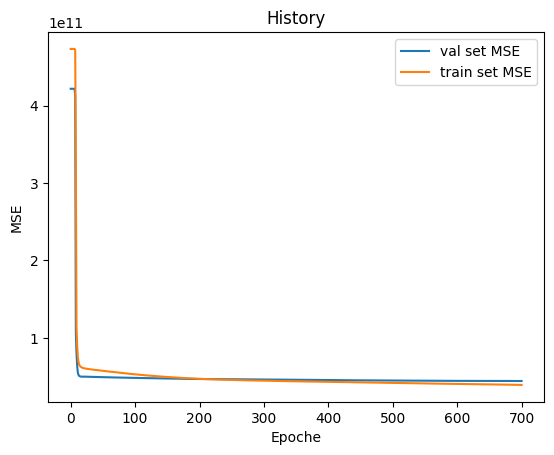

In [80]:
plt.plot(storia.history["val_mean_squared_error"], label ="val set MSE")
plt.plot(storia.history["mean_squared_error"], label ="train set MSE")
plt.title("History")
plt.xlabel("Epoche")
plt.ylabel("MSE")
plt.legend(loc='upper right')
plt.show()

In [81]:
fit = model_nn.predict(x=test_set.drop("prezzo", axis = 1), verbose = 0).flatten()
SSE = ((test_set["prezzo"].to_numpy() - fit)**2).sum()
DEV = ((test_set["prezzo"].to_numpy() - test_set["prezzo"].mean())**2).sum()
R2_nn = 1 - SSE/DEV
R2_nn

0.7134591056591496

In [82]:
modResults.loc[len(modResults.index)] = ["NN L1 pen", R2_nn]

In [83]:
modResults

,model,R2 test set
0,Linear model (benchmark),0.663533
1,Linear model FS,0.660370
2,RF benchmark,0.742509
3,RF regulated,0.758551
4,GB regulated,0.740460
5,NN L1 pen,0.713459


### NN dropout
The dropout regularization will be tested.

In [84]:
from tensorflow.keras.layers import Dropout

In [85]:
def create_modelDrop(size, n_input, drop, seed):
    #Per rendere la stima replicabile
    random.seed(seed)
    seeds= genSeeds(4)
    
    #Struttura del modello
    model = Sequential()
    model.add(keras.Input(shape=(n_input,)))
    model.add(Dense(size[0], activation ="relu", name="Hidden1", kernel_initializer=initializers.RandomNormal(seed = seeds[0]),
                   kernel_regularizer=regularizers.L1(L1)))
    model.add(Dropout(drop))
    model.add(Dense(size[1], activation='relu', name="Hidden2", kernel_initializer=initializers.RandomNormal(seed = seeds[1]),
                   kernel_regularizer=regularizers.L1(L1)))
    model.add(Dropout(drop))
    model.add(Dense(size[2], activation='relu', name="Hidden3", kernel_initializer=initializers.RandomNormal(seed = seeds[2]),
                   kernel_regularizer=regularizers.L1(L1)))
    model.add(Dropout(drop))
    model.add(Dense(1, activation="linear", name="Output", kernel_initializer=initializers.RandomNormal(seed = seeds[3])))

    #Metodo di stima da utilizzare
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics = ["mean_squared_error"])
    
    return model 

In [86]:
random.seed(1)
np.random.seed(1)
tf_set_seed(1)
keras.utils.set_random_seed(1)

In [87]:
#Let's try to regularized using dropout.
#dropPenalties = [i/10 for i in range(1,6)] #The dropout probabilities tried.
dropPenalties = [i/10 for i in range(1,6)] #The dropout probabilities tried.
dropResults = []

seeds = genSeeds(len(dropPenalties))
bestEpochs = []


for drop in dropPenalties:
    model_nn = create_modelDrop([200,200,200],train_set.shape[1] - 1,drop, seeds[dropPenalties.index(drop)])
    storia = model_nn.fit(x = train_set.drop("prezzo", axis = 1), y = train_set["prezzo"],
                      batch_size = 64 , epochs = 1000,
                      validation_data=(validation_set.drop("prezzo", axis = 1),validation_set["prezzo"]), verbose =0,
                      callbacks = callbacks.EarlyStopping(monitor ="val_mean_squared_error", min_delta =0, patience =10))
    print("Worked on drop prob",drop,":",len(storia.history["val_mean_squared_error"]) ,"epochs")
    dropResults.append(min(storia.history["val_mean_squared_error"]))
    bestEpochs.append(storia.history["val_mean_squared_error"].index(min(storia.history["val_mean_squared_error"])) + 1)

dropResults

Worked on drop prob 0.1 : 102 epochs
Worked on drop prob 0.2 : 116 epochs
Worked on drop prob 0.3 : 110 epochs
Worked on drop prob 0.4 : 98 epochs
Worked on drop prob 0.5 : 111 epochs


[52022673408.0, 53348143104.0, 53877166080.0, 53200642048.0, 53909454848.0]

In [ ]:
#In some cases the results improved, but it's not related to regularization, but instead to the random starting point and updating, which is stochastic.
#The best approach would be to replicate each regularization value with different starting random points, but it's too expensive in this case. The neural network
#never came close to the others anyway, so there is really no need to work on it anymore than already done, as there already are models that work way better.

### Possible improvements
As was seen, the results are pretty unstable and volatile. The lower error of a model s not necessarily related to it's regulation, but to the starting point and the random stochastic updates. This means the model has some trouble to reach the global minima. This can be resolved through repated estimation.

# Results 
The results of these models are shown in the table below.

In [88]:
modResults

,model,R2 test set
0,Linear model (benchmark),0.663533
1,Linear model FS,0.660370
2,RF benchmark,0.742509
3,RF regulated,0.758551
4,GB regulated,0.740460
5,NN L1 pen,0.713459


The best model is easily the Random Forest. This is certainly due to the fact it's regularization is closest to the optimal approach, meanwhile the gradient boosting is a bit rougher. As practice, this small project was a success, as it allowed to pratice using Python for regression problems. The best model found, the Random Forest, worked really well in predicting the house price.

### Adding house location
The next step consists in adding the location of the house to the dataset, and repeating model estimation. This data was added later as it was a bit harder to preprocess, but it's an incredibly valuable information.

In [8]:
#THIS IS A COPY-PASTE OF THE PREPROCESSING ALREADY DONE.
houses = pd.read_csv("DATA/casemilano.csv", encoding='unicode_escape')

#Missing data will be removed
#This leads to lose about 35% of observations, but it must be done, as the variables with missing values are important ones, and cannot be excluded.
houses.dropna(inplace=True)
houses = houses.reset_index(drop=True)
# The features will be cleaned.

#Features eliminated
houses = houses.drop('w', axis=1) #It's a constant variable
houses = houses.drop("s", axis=1) #It's unclear the meaning of the variable
#Ascensore recoded.
houses.loc[houses["ascensore"] == "no", "ascensore"] = 0
houses.loc[houses["ascensore"] != 0, "ascensore"] = 1
houses["ascensore"] = houses["ascensore"].astype(bool)
#Parking: more than 2 in shared parking space are merged in "aLotShared".
sharedALot = houses["parcheggio"].value_counts().loc[houses["parcheggio"].value_counts() <=5].index
houses.loc[houses["parcheggio"].apply(lotShared),"parcheggio"] = "aLotShared"
houses["parcheggio"] = houses["parcheggio"].astype(str)
#Features made character. The dtype remain "object"
houses["numero.bagni"] = houses["numero.bagni"].astype(str)
houses["numero.stanze"] = houses["numero.stanze"].astype(str)

#Features made numeric
houses.loc[houses["numero.totale.piani.edificio"] == "1 piano", "numero.totale.piani.edificio"] = 1
houses["numero.totale.piani.edificio"] = houses["numero.totale.piani.edificio"].astype(np.int8)
#Is the house available or not?
houses.loc[houses["disponibile"] == "disponibile","disponibile"] = 1
houses.loc[houses["disponibile"] != 1,"disponibile"] = 0
houses["disponibile"] = houses["disponibile"].astype(bool)
houses.loc[houses["spese.condominiali"] == "nessun costo condominiale", "spese.condominiali"] = 0
houses["spese.condominiali"] = houses["spese.condominiali"].astype(float)
#condizioni has been made made string.
houses["condizioni"] = houses["condizioni"].astype(str)
houses["piano"] = houses["piano"].astype(str)
houses.loc[houses["riscaldamento.centralizzato"] == "centralizzato","riscaldamento.centralizzato"] = 1
houses.loc[houses["riscaldamento.centralizzato"] == "indipendente","riscaldamento.centralizzato"] = 0
houses["riscaldamento.centralizzato"] = houses["riscaldamento.centralizzato"].astype(bool)
houses["classe.di.efficienza.energetica"] = houses["classe.di.efficienza.energetica"].astype(str)

In [9]:
houses.head()

,prezzo,metri.quadrati,numero.bagni,ascensore,numero.stanze,altre.caratteristiche,numero.totale.piani.edificio,parcheggio,disponibile,spese.condominiali,anno.di. Costruzione,condizioni,zona,piano,riscaldamento.centralizzato,classe.di.efficienza.energetica
0,500000.0,57.0,1,True,2,fibra ottica | videocitofono | sistema d'allar...,7,1 in garage/box,True,0.0,2010.0,eccellente / restaurato,porta romana - medaglie d'oro,1,True,e
1,395000.0,92.0,1,True,3,cancello elettrico | fibra ottica | videocitof...,8,no,True,200.0,1960.0,eccellente / restaurato,gallaratese,1,True,e
2,199000.0,38.0,1,False,1,fibra ottica | porta di sicurezza | esposizion...,4,no,True,80.0,1930.0,eccellente / restaurato,navigli - darsena,1,False,g
3,299000.0,45.0,1,False,1,cancello elettrico | fibra ottica | porta di s...,5,no,True,100.0,1911.0,buone condizioni /vivibile,porta romana - medaglie d'oro,1,True,g
4,1290000.0,170.0,2,True,4,porta di sicurezza | terrazza | terrazza |port...,6,no,True,500.0,1970.0,buone condizioni /vivibile,de angeli,6,True,g


In [10]:
#The "area" feature is a bit problematic: it has a lot of unique values, with a lot of them appering only once or twice.
#As it is, it's difficult to use in models. A second dataset will be used: "mappe.xlsx", which contains the geographical coordinates
# of the "area".
mappe = pd.read_excel('DATA/mappe.xlsx')

In [11]:
mappe.head()

,città,zona,Latitudine,Longitudine
0,Milano,affori,45.515798,9.172310
1,Milano,amendola - buonarroti,45.473562,9.151326
2,Milano,arco della pace,45.475693,9.172451
3,Milano,arena,45.477031,9.178221
4,Milano,argonne - corsica,45.463586,9.233394
